## I use this notebook to preview the readme as I'm writing it.

**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points
### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---
### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the first code cell of the Jupyter notebook named `vehicle_detection.ipynb`.  

I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:
[image1]: ./examples/car_not_car.png
[image2]: ./examples/HOG_example.jpg

![alt text][image1]

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:


![alt text][image2]

### Import all modules and given functions

In [50]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import glob
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

from vehicle import *

%matplotlib inline


In [51]:
# Read in all vehicle and non-vehicle images
# I adapted this code from that which was provided in the Q&A from Udacity

basedir = './vehicles/vehicles/'

image_types = os.listdir(basedir)
image_types.remove('.DS_Store')
print('Image sources for vehicle images:', image_types)

cars = []
# Add all the images from each subfolder in `vehicles` to the list `cars`.
for imtype in image_types:
    car_list_from_subfolder = glob.glob(basedir+imtype+'/*')
    cars.extend(car_list_from_subfolder)
    print('Number of vehicle images found in %s: %d' % (imtype, len(car_list_from_subfolder)))
    
print('Total number of vehicle images found:', len(cars))
with open("cars.txt", 'w') as f:
    for fn in cars:
        f.write(fn+'\n')

Image sources for vehicle images: ['GTI_Right', 'KITTI_extracted', 'GTI_MiddleClose', 'GTI_Far', 'GTI_Left']
Number of vehicle images found in GTI_Right: 664
Number of vehicle images found in KITTI_extracted: 5966
Number of vehicle images found in GTI_MiddleClose: 419
Number of vehicle images found in GTI_Far: 834
Number of vehicle images found in GTI_Left: 909
Total number of vehicle images found: 8792


In [52]:
# Read in all vehicle and non-vehicle images
# I adapted this code from that which was provided in the Q&A from Udacity

basedir = './non-vehicles/non-vehicles/'

image_types = os.listdir(basedir)
image_types.remove('.DS_Store')
print('Image sources for non-vehicle images:', image_types)

notcars = []
# Add all the images from each subfolder in `vehicles` to the list `cars`.
for imtype in image_types:
    notcar_list_from_subfolder = glob.glob(basedir+imtype+'/*')
    notcars.extend(notcar_list_from_subfolder)
    print('Number of non-vehicle images found in %s: %d' % (imtype, len(notcar_list_from_subfolder)))
    
print('Total number of non-vehicle images found:', len(notcars))
with open("notcars.txt", 'w') as f:
    for fn in notcars:
        f.write(fn+'\n')

Image sources for non-vehicle images: ['Extras', 'GTI']
Number of non-vehicle images found in Extras: 5068
Number of non-vehicle images found in GTI: 3900
Total number of non-vehicle images found: 8968


In [53]:
# Choose a random car and non-car image.
# This code was adatped from the Q&A

car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(cars))

# Read in the images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Define feature parameters

color_space = 'YCrCb'
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
spatial_size = (16, 16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True


car_features, car_hog_image = single_img_features(car_image, 
                                                  cspace=color_space,
                                                  spatial_size=spatial_size,
                                                  hist_bins=hist_bins,
                                                  orient=orient,
                                                  pix_per_cell=pix_per_cell,
                                                  cell_per_block=cell_per_block,
                                                  hog_channel=hog_channel,
                                                  spatial_feat=spatial_feat,
                                                  hist_feat=hist_feat,
                                                  hog_feat=hog_feat,
                                                  vis=True)
notcar_features, notcar_hog_image = single_img_features(notcar_image, 
                                                        cspace=color_space,
                                                        spatial_size=spatial_size,
                                                        hist_bins=hist_bins,
                                                        orient=orient,
                                                        pix_per_cell=pix_per_cell,                                                        
                                                        cell_per_block=cell_per_block,
                                                        hog_channel=hog_channel,
                                                        spatial_feat=spatial_feat,
                                                        hist_feat=hist_feat,
                                                        hog_feat=hog_feat,
                                                        vis=True)
images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ["car_image", "car_hog_image", "notcar_image", "notcar_hog_image"]
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)

NameError: name 'cv2' is not defined

In [5]:
# Define feature parameters

color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

# Train on a subset
t=time.time()
n_samples = 500
random_idxs = np.random.randint(0, len(cars), n_samples)
# test_cars = np.array(cars)[random_idxs]
# test_notcars = np.array(notcars)[random_idxs]
test_cars = cars
test_notcars = notcars


car_features =   extract_features(test_cars, 
                                  color_space=color_space,
                                  spatial_size=spatial_size,
                                  hist_bins=hist_bins,
                                  orient=orient,
                                  pix_per_cell=pix_per_cell,
                                  cell_per_block=cell_per_block,
                                  hog_channel=hog_channel,
                                  spatial_feat=spatial_feat,
                                  hist_feat=hist_feat,
                                  hog_feat=hog_feat,
                                  vis=False)

notcar_features =  extract_features(test_notcars, 
                                    color_space=color_space,
                                    spatial_size=spatial_size,
                                    hist_bins=hist_bins,
                                    orient=orient,
                                    pix_per_cell=pix_per_cell,                                                        
                                    cell_per_block=cell_per_block,
                                    hog_channel=hog_channel,
                                    spatial_feat=spatial_feat,
                                    hist_feat=hist_feat,
                                    hog_feat=hog_feat,
                                    vis=False)

print(time.time()-t, 'Seconds to compute features...')

# Here the actual training begins.

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 5))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

75.28316330909729 Seconds to compute features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
20.21 Seconds to train SVC...
Test Accuracy of SVC =  0.99381
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
0.00172 Seconds to predict 10 labels with SVC


In [6]:
# Explore color spaces

#### 2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters and...

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using...

1.3394129276275635 seconds to process one image searching 312 windows
1.3269484043121338 seconds to process one image searching 312 windows
1.2765476703643799 seconds to process one image searching 312 windows
1.2968971729278564 seconds to process one image searching 312 windows
1.2853593826293945 seconds to process one image searching 312 windows
1.2917423248291016 seconds to process one image searching 312 windows


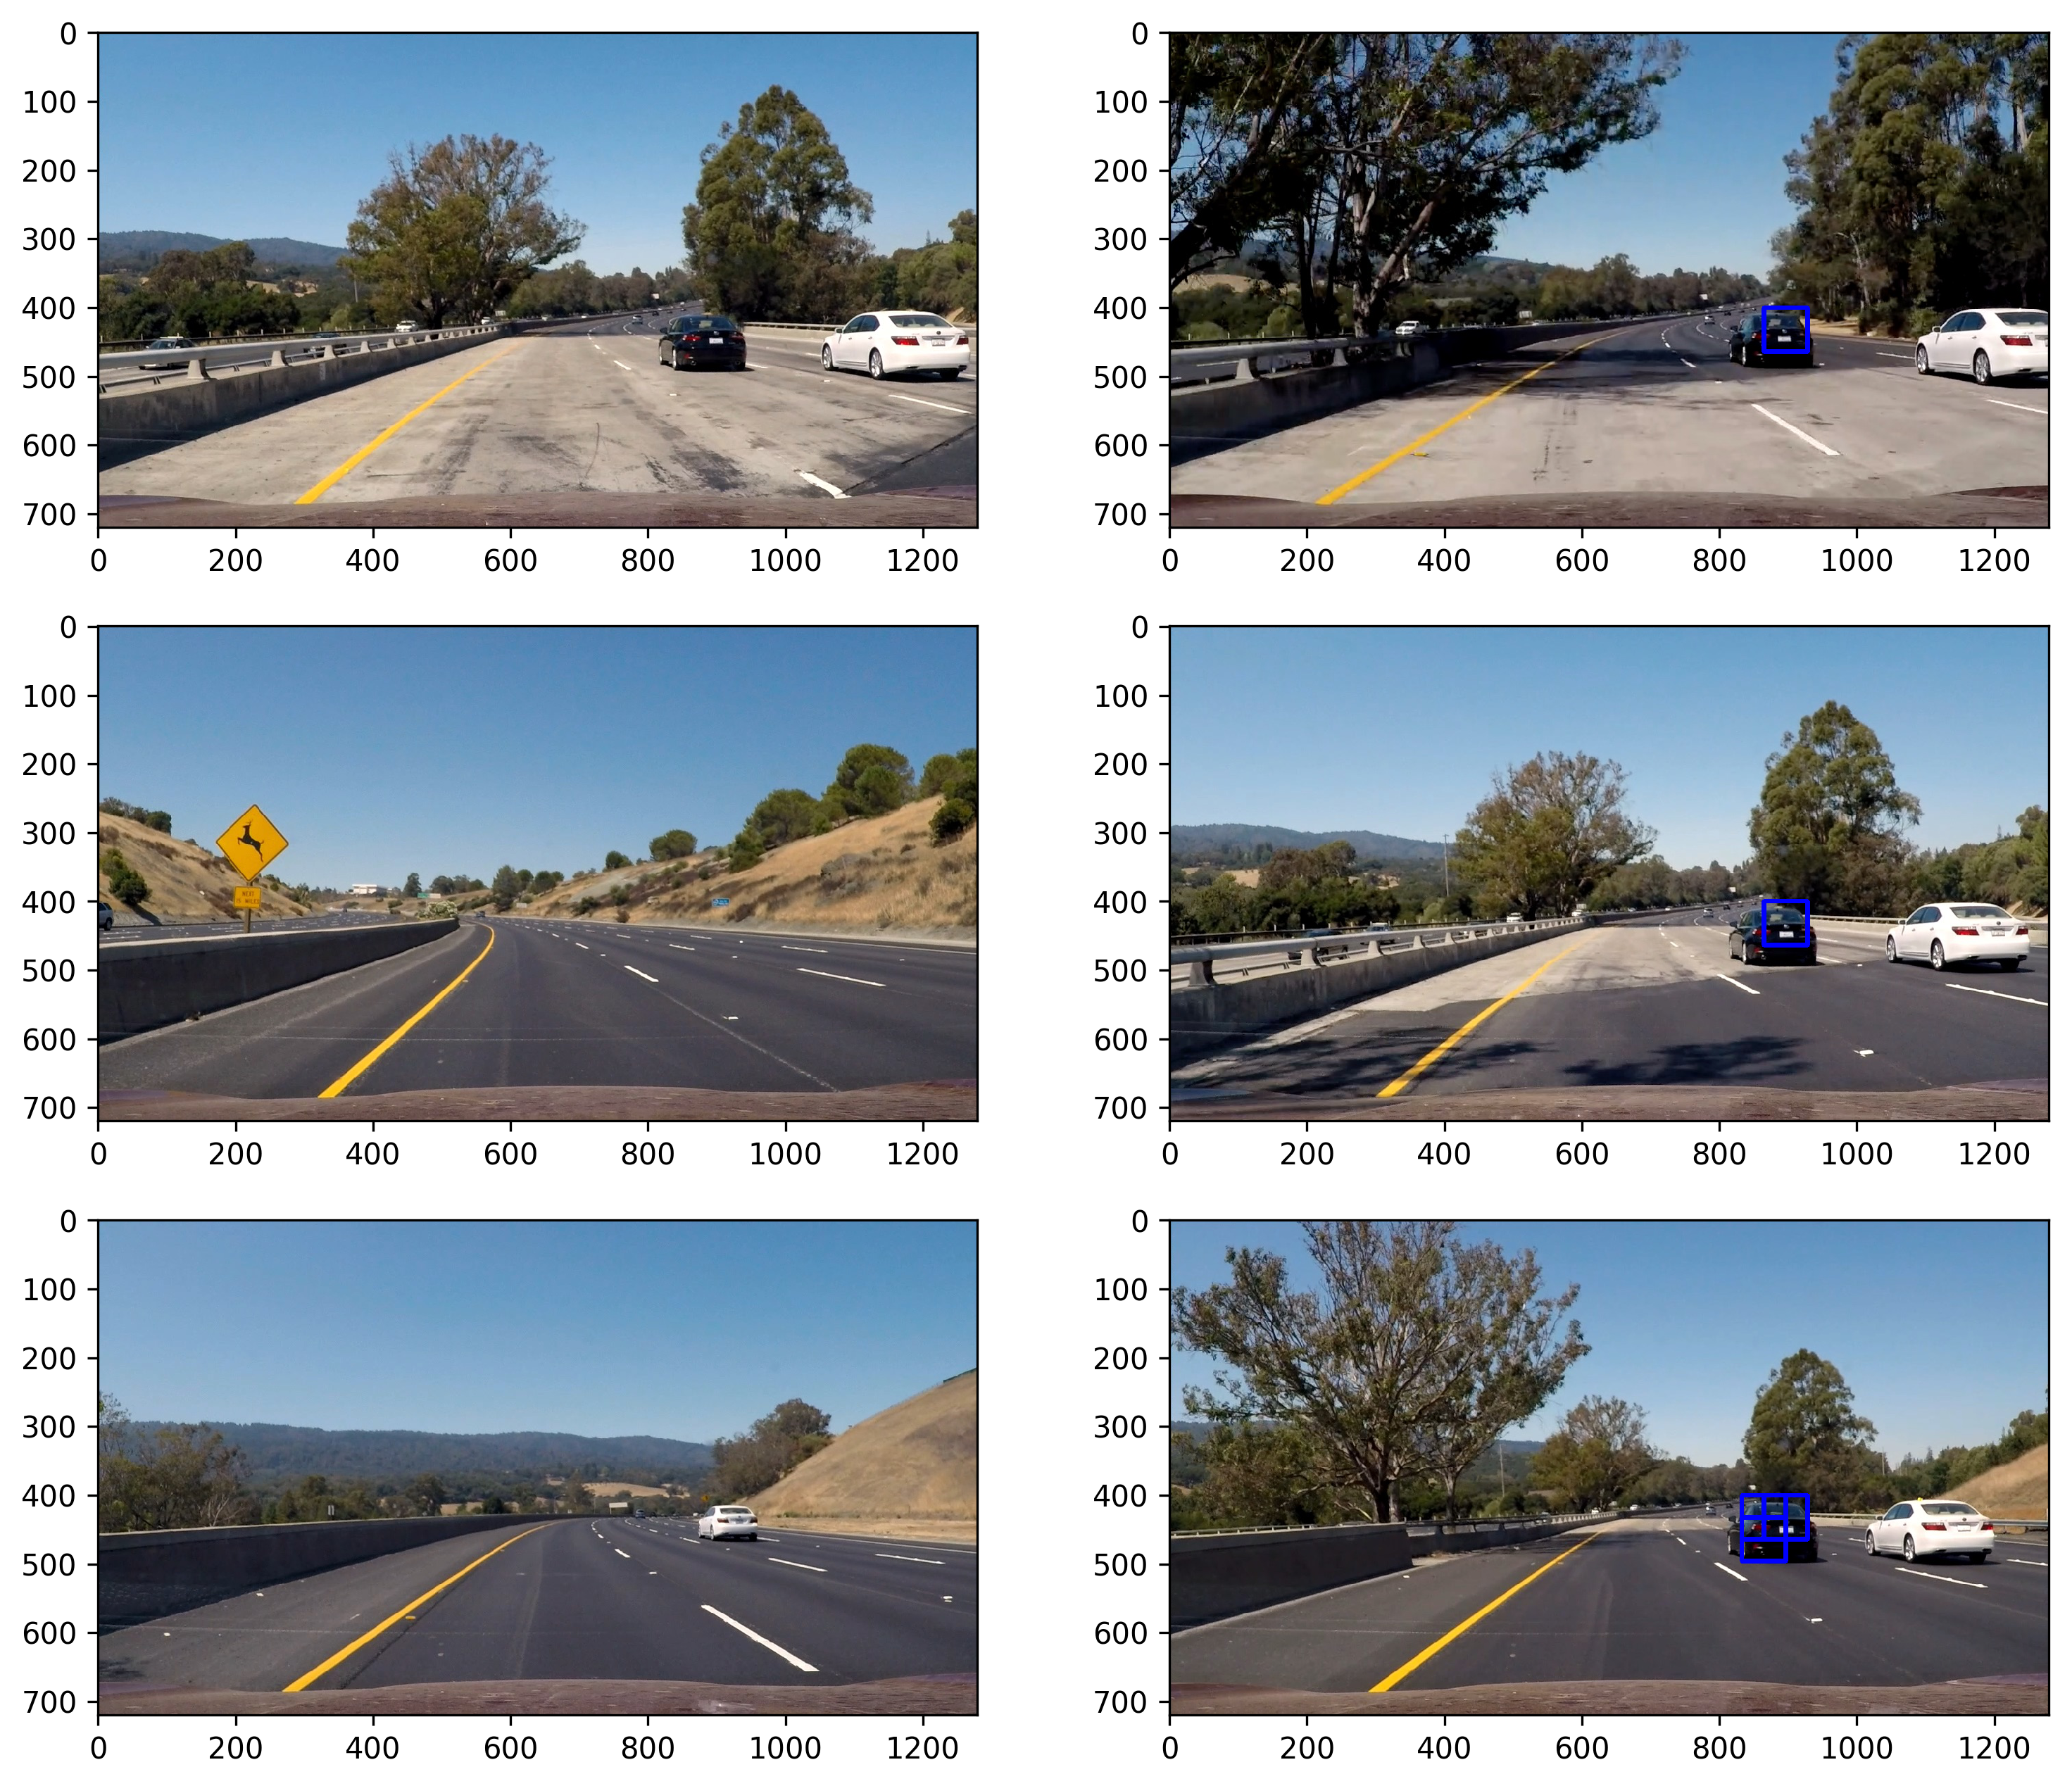

In [7]:
# Sliding Window
image = mpimg.imread('./test_images/test1.jpg')
searchpath = './test_images/*'
example_images = glob.glob(searchpath)

# Ignore the sky and the hood of the car.
y_start_stop=[400, 700]
x_start_stop=[None, None]
images = []
titles =[]
# An overlap of .5 gives each area coverage by 4 windows.
overlap = 0.5
# def search_windows(img, windows, clf, scaler, color_space='RGB', 
#                     spatial_size=(32, 32), hist_bins=32, 
#                     hist_range=(0, 256), orient=9, 
#                     pix_per_cell=8, cell_per_block=2, 
#                     hog_channel=0, spatial_feat=True, 
#                     hist_feat=True, hog_feat=True):
# Just using the very basic method for now.  
# I'll make it smarter after getting the basic pipeline running.
for img_src in example_images:
    t1 = time.time()
    image = mpimg.imread(img_src)
    
    # Get a copy of the image on which to draw the boxes.
    draw_img = np.copy(image)
    
    # Handle the differences between .png and .jpg
    image = image.astype(np.float32)/255
    
    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(overlap, overlap))
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

                     
    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)   
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'seconds to process one image searching', len(windows),'windows')
                  
fig = plt.figure(figsize=(12, 18), dpi=300)
visualize(fig, 5, 2,images, titles)

### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I decided to search random window positions at random scales all over the image and came up with this (ok just kidding I didn't actually ;):
[image3]: ./examples/sliding_windows.jpg

![alt text][image3]

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.  Here are some example images:

![alt text][image4]

---

0.4769718647003174 seconds to process
0.4333617687225342 seconds to process
0.3693068027496338 seconds to process
0.3930346965789795 seconds to process
0.4791224002838135 seconds to process
0.34781718254089355 seconds to process


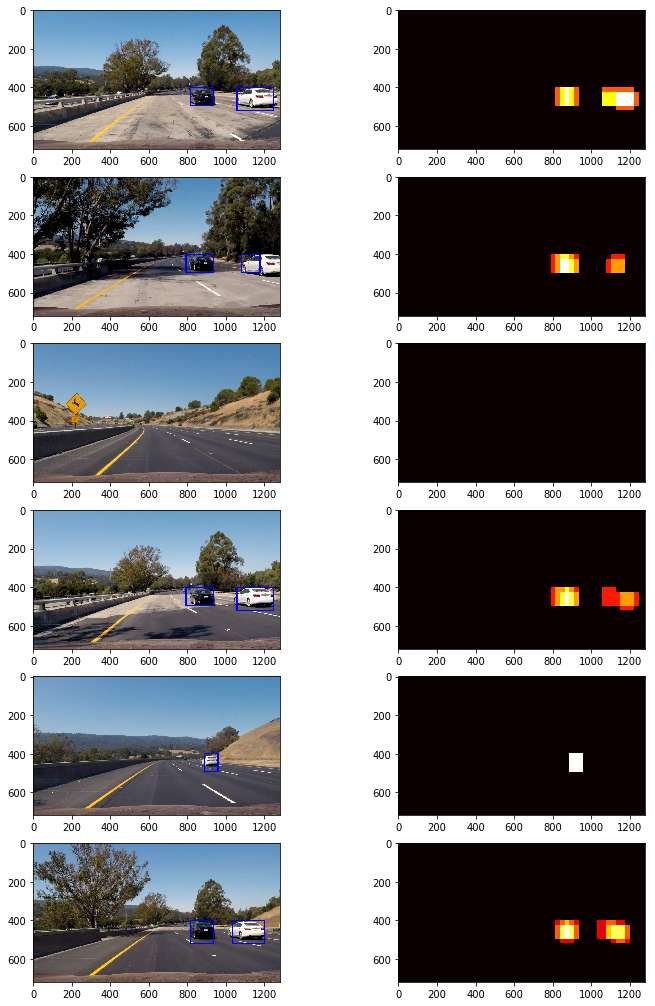

In [8]:
out_images = []
out_maps = []
out_labels = []
ystart = 400
ystop = 656
scale = 1.5
cells_per_step = 2
window = 64

    
# Iterate over test images
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    
    out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                   orient, pix_per_cell,
                                   cell_per_block, spatial_size, hist_bins,
                                   cells_per_step, window)
    # Make a heatmap from the bounding boxes
    heatmap = np.zeros_like(out_img[:,:,0])
    heatmap = add_heat(heatmap, bbox_list)
    heatmap = apply_threshold(heatmap, 1)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    out_images.append(draw_img)
    out_images.append(heatmap)
    print(time.time()-t1, 'seconds to process')

    
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, ['' for x in example_images*2])
# plt.imshow(out_img)
# plt.imshow(heatmap)


### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

[video1]: ./project_video.mp4
Here's a [link to my video result](./project_video.mp4)

In [45]:
def process_image(img):
    """Returns an image with bounding boxes around each car in the given image."""
    
    out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                   orient, pix_per_cell,
                                   cell_per_block, spatial_size, hist_bins,
                                   cells_per_step, window)
    # Make a heatmap from the bounding boxes
    heatmap = np.zeros_like(out_img[:,:,0])
    heatmap = add_heat(heatmap, bbox_list)
    heatmap = apply_threshold(heatmap, 1)
    
    # Add heatmap to recent history
    history.recent_heatmaps.append(heatmap)
    
    if len(history.recent_heatmaps) > history.history_length:
        # Remove the oldest map from the history.
        history.recent_heatmaps = history.recent_heatmaps[1:]
        
    # Get the total heatmap over n frames
    sum_heatmap = np.sum(history.recent_heatmaps, axis=0)
    # Filter out predictions that happened for 3 or less frames over n frames.
    thres_heatmap = apply_threshold(sum_heatmap, 3)
    # Take the average to bring the heatmap back to expected range.
    # avg_heatmap = thres_heatmap // len(history.recent_heatmaps)
    
    labels = label(thres_heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

In [43]:
class History():
    def __init__(self, history_length):
        # Length of history to keep for heatmaps
        self.history_length = history_length 
        # List of recent heatmaps to average.
        self.recent_heatmaps = [] 

In [49]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'test.mp4'


history_length = 10
history = History(history_length)
clip = VideoFileClip('./project_video.mp4').subclip(25,26)
#clip = VideoFileClip('./test_video.mp4')
test_clip = clip.fl_image(process_image)

test_clip.write_videofile(test_output, audio=False)

NameError: name 'np' is not defined

#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

Here's an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:

### Here are six frames and their corresponding heatmaps:
[image5]: ./examples/bboxes_and_heat.png
[image6]: ./examples/labels_map.png
[image7]: ./examples/output_bboxes.png

![alt text][image5]

### Here is the output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all six frames:
![alt text][image6]

### Here the resulting bounding boxes are drawn onto the last frame in the series:
![alt text][image7]



---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  